In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets.mnist import load_data
from keras.models import Sequential
from keras.layers import Dense, Reshape, Conv2D, Conv2DTranspose, LeakyReLU, Flatten, Dropout
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


Get the MNIST Data and split it accordingly. Later have a glance at the data.

In [3]:
(train_x,train_y),(test_x,test_y) = load_data()

11493376/11490434 [==============================] - 2s 0us/step


In [4]:
print('Train Set: {}, {}'.format(train_x.shape,train_y.shape))
print('Test Set: {}, {}'.format(test_x.shape,test_y.shape))

Train Set: (60000, 28, 28), (60000,)
Test Set: (10000, 28, 28), (10000,)


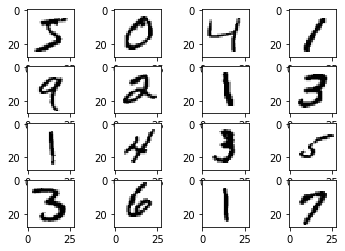

In [5]:
for i in range(16):
  plt.subplot(4, 4, 1 + i)
  plt.imshow(train_x[i], cmap='gray_r')


The first step is to define the discriminator model.

The model must take a sample image from our dataset as input and output a classification prediction as to whether the sample is real or fake.

This is a binary classification problem:

1.   Inputs: Image with one channel and 28×28 pixels in size.
2.   Outputs: Binary classification, likelihood the sample is real (or fake).

The discriminator model has two convolutional layers with 64 filters each, a small kernel size of 3, and larger than normal stride of 2. The model has no pooling layers and a single node in the output layer with the sigmoid activation function to predict whether the input sample is real or fake. The model is trained to minimize the binary cross entropy loss function, appropriate for binary classification.


    






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 64)          0         
_____________________________________

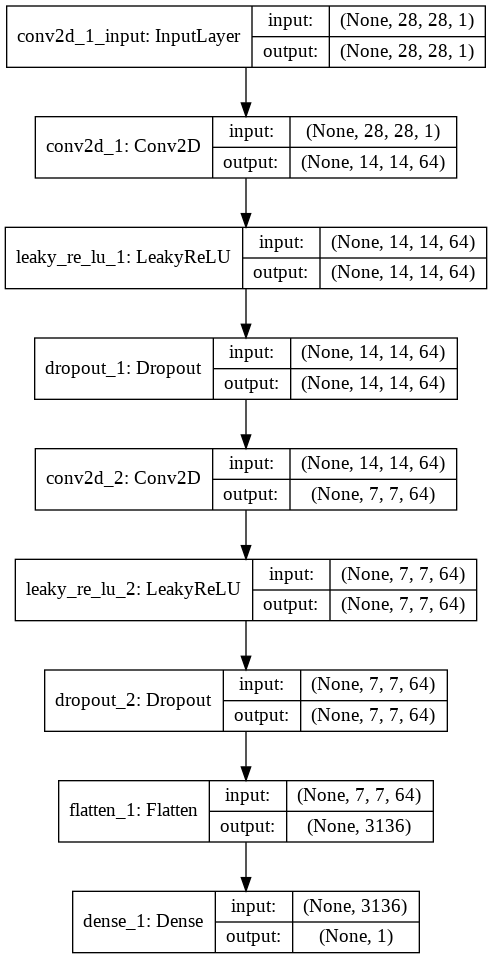

In [6]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

# define model
model = define_discriminator()
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

The images are 2D arrays of pixels and convolutional neural networks expect 3D arrays of images as input, where each image has one or more channels.

We must update the images to have an additional dimension for the grayscale channel. We can do this using the expand_dims() NumPy function and specify the final dimension for the channels-last image format.

Finally, we must Normalize the pixel values [0,255] to a range [0,1]

In [0]:
def load_real_samples():
	# load mnist dataset
	(train_x, _), (_, _) = load_data()
	# expand to 3d, e.g. add channels dimension
	X = np.expand_dims(train_x, axis=-1)
	# convert from unsigned ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [0,1]
	X = X / 255.0
	return X

# Real Images

The generate_real_samples() function below will take the training dataset as an argument and will select a random subsample of images; it will also return class labels for the sample, specifically a class label of 1, to indicate real images.

In [0]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = np.random.randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = np.ones((n_samples, 1)) # real image lable = 1 to identify its a real image
	return X, y

# Fake images (For Intitial Discriminator Training)

We don’t have a generator model yet, so instead, we can generate images comprised of random pixel values, specifically random pixel values in the range [0,1] like our scaled real images.

In [0]:
# generate n fake samples with class labels
def generate_fake_samples(n_samples):
	# generate uniform random numbers in [0,1]
	X = np.random.rand(28 * 28 * n_samples)
	# reshape into a batch of grayscale images
	X = X.reshape((n_samples, 28, 28, 1))
	# generate 'fake' class labels (0)
	y = np.zeros((n_samples, 1))
	return X, y

Finally, we need to train the discriminator model.

This involves repeatedly retrieving samples of real images and samples of generated images and updating the model for a fixed number of iterations.

The model will learn to discriminate between real and fake (randomly generated) images rapidly, therefore, not many batches will be required before it learns to discriminate perfectly.

In this case, the discriminator model learns to tell the difference between real and randomly generated MNIST images very quickly, in about 50 batches.

# Discreminator Model:

In [0]:
#Running the example first defines the model, loads the MNIST dataset, then trains the discriminator model.

# train the discriminator model
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_iter):
		# get randomly selected 'real' samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		# update discriminator on real samples
		_, real_acc = model.train_on_batch(X_real, y_real)
		# generate 'fake' examples
		X_fake, y_fake = generate_fake_samples(half_batch)
		# update discriminator on fake samples
		_, fake_acc = model.train_on_batch(X_fake, y_fake)
		# summarize performance
		print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

In [12]:
model = define_discriminator()
# load image data
dataset = load_real_samples()
# fit the model
train_discriminator(model, dataset)




>1 real=65% fake=41%
>2 real=76% fake=49%
>3 real=71% fake=59%
>4 real=77% fake=84%
>5 real=82% fake=90%
>6 real=73% fake=96%
>7 real=77% fake=98%
>8 real=87% fake=98%
>9 real=72% fake=100%
>10 real=85% fake=100%
>11 real=83% fake=100%
>12 real=85% fake=100%
>13 real=80% fake=100%
>14 real=80% fake=100%
>15 real=88% fake=100%
>16 real=88% fake=100%
>17 real=88% fake=100%
>18 real=88% fake=100%
>19 real=85% fake=100%
>20 real=86% fake=100%
>21 real=94% fake=100%
>22 real=95% fake=100%
>23 real=92% fake=100%
>24 real=95% fake=100%
>25 real=94% fake=100%
>26 real=92% fake=100%
>27 real=96% fake=100%
>28 real=98% fake=100%
>29 real=99% fake=100%
>30 real=100% fake=100%
>31 real=99% fake=100%
>32 real=98% fake=100%
>33 real=100% fake=100%
>34 real=100% fake=100%
>35 real=100% fake=100%
>36 real=100% fake=100%
>37 real=100% fake=100%
>38 real=100% fake=100%
>39 real=100% fake=100%
>40 real=100% fake=100%
>41 real=100% fake=100%
>42 real=100% fake=100%
>43 real=100% fake=100%
>44 real=100%

Developing a generator model requires that we transform a vector from the latent space with, 100 dimensions to a 2D array with 28×28 or 784 values.

There are a number of ways to achieve this but there is one approach that has proven effective at deep convolutional generative adversarial networks. It involves two main elements: 



*   The first is a Dense layer as the first hidden layer that has enough nodes to represent a low-resolution version of the output image. Specifically, an image half the size (one quarter the area) of the output image would be 14×14 or 196 nodes, and an image one quarter the size (one eighth the area) would be 7×7 or 49 nodes.

We don’t just want one low-resolution version of the image; we want many parallel versions or interpretations of the input. This is a pattern in convolutional neural networks where we have many parallel filters resulting in multiple parallel activation maps, called feature maps, with different interpretations of the input. We want the same thing in reverse: many parallel versions of our output with different learned features that can be collapsed in the output layer into a final image. The model needs space to invent, create, or generate.

Therefore, the first hidden layer, the Dense, needs enough nodes for multiple low-resolution versions of our output image, such as 128.

The next major architectural innovation involves upsampling the low-resolution image to a higher resolution version of the image.

There are two common ways to do this **upsampling process**, sometimes called **deconvolution**.

One way is to use an UpSampling2D layer (like a reverse pooling layer) followed by a normal Conv2D layer. The other and perhaps more modern way is to combine these two operations into a single layer, called a **Conv2DTranspose**. We will use this latter approach for our generator.

The Conv2DTranspose layer can be configured with a stride of (2×2) that will quadruple the area of the input feature maps (double their width and height dimensions). It is also good practice to use a kernel size that is a factor of the stride (e.g. double) to avoid a checkerboard pattern that can be observed when upsampling.

# Generator Model

In [0]:
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image ( Low resolution Images )
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14 ( Upsampling using Con2DTranspose in order to improve the resolution of the image)
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model

This model cannot do much at the moment.

Nevertheless, we can demonstrate how to use it to generate samples. This is a helpful demonstration to understand the generator as just another model, and some of these elements will be useful later.

## Demonstration of New Generator Model

The first step is to generate new points in the latent space. We can achieve this by calling the randn() NumPy function for generating arrays of random numbers drawn from a standard Gaussian.

**The array of random numbers can then be reshaped into samples, that is n rows with 100 elements per row**. The generate_latent_points() function below implements this and generates the desired number of points in the latent space that can be used as input to the generator model.

Next, we can use the generated points as input to the generator model to generate new samples, then plot the samples.

We can update the generate_fake_samples() function from the previous section to take the generator model as an argument and use it to generate the desired number of samples by first calling the generate_latent_points() function to generate the required number of points in latent space as input to the model.

In [0]:
# Generate Gaussian Noise and reshape into vectors of noises from normal distribution. These n-dim noise vectors will be input inorder to generate fake samples.

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [0]:
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = np.zeros((n_samples, 1))
	return X, y

We can then plot the generated samples as we did the real MNIST examples in the first section by calling the imshow() function with the reversed grayscale color map. As the model is not trained, the generated images are completely random pixel values in [0, 1].

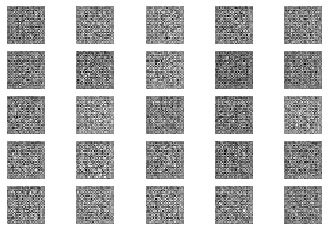

In [16]:
# size of the latent space. Here we generate vectors of 100 dimentions.
latent_dim = 100
# define the discriminator model
model = define_generator(latent_dim)
# generate samples
n_samples = 25
X, _ = generate_fake_samples(model, latent_dim, n_samples)
# plot the generated samples
for i in range(n_samples):
	# define subplot
	plt.subplot(5, 5, 1 + i)
	# turn off axis labels
	plt.axis('off')
	# plot single image
	plt.imshow(X[i, :, :, 0], cmap='gray_r')
# show the figure
plt.show()

**Note:** The Generator model here is not trained in a Adverserial Setup. Thus it only outputs noise above, the generator model is not compiled and does not specify a loss function or optimization algorithm at this instance.

# Training a Generator Model:

**The weights in the generator model are updated based on the performance of the discriminator model.**

**When the discriminator is good at detecting fake samples, the generator is updated more, and when the discriminator model is relatively poor or confused when detecting fake samples, the generator model is updated less.**

**There may be many ways to implement this using the Keras API, but perhaps the simplest approach is to create a new model that combines the generator and discriminator models.**

### Working of GAN:

Specifically, a new GAN model can be defined that stacks the generator and discriminator such that the generator receives as input random points in the latent space and generates samples that are fed into the discriminator model directly, classified, and the output of this larger model can be used to update the model weights of the generator.

Only the discriminator is concerned with distinguishing between real and fake examples, therefore the discriminator model can be trained in a standalone manner on examples of each, as we did in the section on the discriminator model above.

The generator model is **only concerned with the discriminator’s performance on fake examples**. Therefore, we will **mark all of the layers in the discriminator as not trainable when it is in an Adverserial Setup so that they can not be updated and overtrained on fake examples.**

Another important note during training GAN is we want the discriminator to think that the samples output by the generator are real, not fake. **Therefore, when the generator is trained as part of the GAN model, we will mark the generated samples as real (class 1).**

###Why would we want to do this?

We can imagine that the discriminator will then classify the generated samples as not real (class 0) or a low probability of being real (0.3 or 0.5). The backpropagation process used to update the model weights will see this as a large error and will update the model weights (i.e. only the weights in the generator) to correct for this error, in turn making the generator better at generating good fake samples.

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_6 (Sequential)    (None, 28, 28, 1)         1164289   
_________________________________________________________________
sequential_5 (Sequential)    (None, 1)                 40705     
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


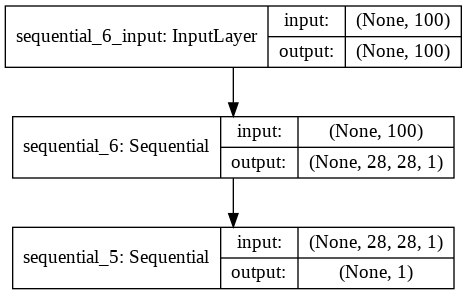

In [17]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model
 
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# summarize gan model
gan_model.summary()
# plot gan model
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

The define_gan() function above takes as arguments the already-defined generator and discriminator models and creates the new third model involving these two models (Stacking these above two models). The weights in the discriminator are marked as not trainable, which only affects the weights as seen by the GAN model and not the standalone discriminator model. **This third model now places the Generator model and Discreminator model in an Adverserial Setup**

In [0]:
# train the composite model
def train_gan(gan_model, latent_dim, n_epochs=100, n_batch=256):
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)

First, the number of batches within an epoch is defined by how many times the batch size divides into the training dataset. **We have a dataset size of 60K samples, so with rounding down, there are 234 batches per epoch.**

The discriminator model is updated once per batch by combining one half a batch of fake and real examples into a single batch via the vstack() NumPy function. You could update the discriminator with each half batch separately (recommended for more complex datasets) but combining the samples into a single batch will be faster over a long run, especially when training on GPU hardware.

Finally, we report the loss each batch. **It is critical to keep an eye on the loss over batches. The reason for this is that a crash in the discriminator loss indicates that the generator model has started generating rubbish examples that the discriminator can easily discriminate.**

**Monitor the discriminator loss and expect it to hover around 0.5 to 0.8 per batch on this dataset. The generator loss is less critical and may hover between 0.5 and 2 or higher on this dataset**. A clever way is to detect the crashing loss of the discriminator, halt, and then restart the training process

In [0]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# create training set for the discriminator
			X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
			# update discriminator model weights
			d_loss, _ = d_model.train_on_batch(X, y)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = np.ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)

# Evaluation of GAN models:

Generally, there are no objective ways to evaluate the performance of a GAN model.

We cannot calculate this objective error score for generated images.

Instead, images must be subjectively evaluated for quality by a human operator. This means that we cannot know when to stop training without looking at examples of generated images. In turn, the adversarial nature of the training process means that the generator is changing after every batch, meaning that once “good enough” images can be generated, the subjective quality of the images may then begin to vary, improve, or even degrade with subsequent updates.

There are three ways to handle this complex training situation.

* Periodically evaluate the classification accuracy of the discriminator on real and fake images. 
* Periodically generate many images and save them to file for subjective review.
* Periodically save the generator model.

All three of these actions can be performed at the same time for a given training epoch, such as every five or 10 training epochs. The result will be a saved generator model for which we have a way of subjectively assessing the quality of its output and objectively knowing how well the discriminator was fooled at the time the model was saved.

Training the GAN over many epochs, such as hundreds or thousands of epochs, will result in many snapshots of the model that can be inspected and from which specific outputs and models can be cherry-picked for later use.

First, we can define a function called summarize_performance() function that will summarize the performance of the discriminator model. It does this by retrieving a sample of real MNIST images, as well as generating the same number of fake MNIST images with the generator model, then evaluating the classification accuracy of the discriminator model on each sample and reporting these scores.


    
    


In [0]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch + 1)
	g_model.save(filename)

In [0]:
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	plt.savefig(filename)
	plt.close()

In [22]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 1/234, d=0.709, g=0.683
>1, 2/234, d=0.701, g=0.698
>1, 3/234, d=0.696, g=0.713


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 4/234, d=0.684, g=0.730
>1, 5/234, d=0.676, g=0.746
>1, 6/234, d=0.672, g=0.760
>1, 7/234, d=0.667, g=0.775
>1, 8/234, d=0.661, g=0.786
>1, 9/234, d=0.656, g=0.799
>1, 10/234, d=0.652, g=0.801
>1, 11/234, d=0.649, g=0.802
>1, 12/234, d=0.653, g=0.794
>1, 13/234, d=0.658, g=0.772
>1, 14/234, d=0.658, g=0.757
>1, 15/234, d=0.658, g=0.741
>1, 16/234, d=0.662, g=0.727
>1, 17/234, d=0.658, g=0.716
>1, 18/234, d=0.657, g=0.707
>1, 19/234, d=0.655, g=0.703
>1, 20/234, d=0.650, g=0.699
>1, 21/234, d=0.641, g=0.697
>1, 22/234, d=0.633, g=0.696
>1, 23/234, d=0.632, g=0.695
>1, 24/234, d=0.623, g=0.695
>1, 25/234, d=0.618, g=0.695
>1, 26/234, d=0.614, g=0.695
>1, 27/234, d=0.602, g=0.695
>1, 28/234, d=0.595, g=0.696
>1, 29/234, d=0.586, g=0.697
>1, 30/234, d=0.578, g=0.697
>1, 31/234, d=0.569, g=0.699
>1, 32/234, d=0.560, g=0.700
>1, 33/234, d=0.545, g=0.701
>1, 34/234, d=0.536, g=0.703
>1, 35/234, d=0.529, g=0.704
>1, 36/234, d=0.518, g=0.706
>1, 37/234, d=0.508, g=0.708
>1, 38/234, d=0.498,

The model performance is reported every batch, including the loss of both the discriminative (d) and generative (g) models. The generator is evaluated every 20 epochs, resulting in 10 evaluations, 10 plots of generated images, and 10 saved models.In this case, we can see that the accuracy fluctuates over training. When viewing the discriminator model’s accuracy score in concert with generated images, we can see that the accuracy on fake examples does not correlate well with the subjective quality of images, but the accuracy for real examples may.

It is crude and possibly unreliable metric of GAN performance, along with loss.

More training, beyond some point, does not mean better quality generated images.

In this case, the results after 10 epochs are low quality, although we can see that the generator has learned to generate centered figures in white on a back background (recall we have inverted the grayscale in the plot).

After 20 or 30 more epochs, the model begins to generate very plausible MNIST figures, suggesting that 100 epochs are probably not required for the chosen model configurations.

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


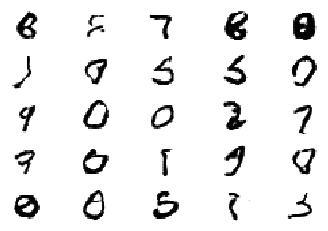

In [23]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()

# load model
model = load_model('generator_model_100.h5')
# generate images
latent_points = generate_latent_points(100, 25)
# generate images
X = model.predict(latent_points)
# plot the result
save_plot(X, 5)